## Bayesian Multiclass Neural Network

In this notebook, we create a neural network with 4 inputs and 3 outputs (categorical). 
The network has 2 hidden layers with 5 neurons each.
The activation function used is `tanh` and the optimization function is `ADVI`.

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import theano
floatX = theano.config.floatX

`create_multiclass_nn` is a function which creates the neural network's model. As arguments, it requires the dataset in the form of X and Y. The Y must not be OneHotEncoded - just leave it as it is.

In [2]:
def create_multiclass_nn(X, Y, hidden=5):
    
    features = X.shape[1]
    classes = np.bincount(Y).shape[0]
    
    w_layer1 = np.random.randn(features, hidden).astype(floatX)
    w_layer21 = np.random.randn(hidden, hidden).astype(floatX)
    w_layer22 = np.random.randn(hidden, hidden).astype(floatX)
    out = np.random.randn(hidden, classes).astype(floatX)
    
    with pm.Model() as neural_network:
        X = pm.Data('nn_input', X)
        Y = pm.Data('nn_output', Y)
        
        w1 = pm.Normal('w_in', mu=0, sigma=1, shape=(features, hidden), testval=w_layer1)
        w21 = pm.Normal('w_hidden1', mu=0, sigma=1, shape=(hidden, hidden), testval=w_layer21)
        w22 = pm.Normal('w_hidden2', mu=0, sigma=1, shape=(hidden, hidden), testval=w_layer22)
        w3 = pm.Normal('w_out', mu=0, sigma=1, shape=(hidden, classes), testval=out)
        
        activation_1 = pm.math.tanh(pm.math.dot(X, w1))
        activation_2 = pm.math.tanh(pm.math.dot(activation_1, w21))
        activation_3 = pm.math.tanh(pm.math.dot(activation_2, w22))
        activation_4 = pm.math.tanh(pm.math.dot(activation_3, w3))
        
        act_out = theano.tensor.nnet.softmax(activation_4)
        p_out = pm.Deterministic('p_out', act_out)
        out = pm.Categorical('out', act_out, observed=Y)#, total_size=classes)
        
    return neural_network

In [3]:
import theano.tensor as T
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, make_blobs
from sklearn.model_selection import train_test_split
set_tt_rng(MRG_RandomStreams())

Create a random dataset based on a seed `random_state`. The dataset is also renormalized and a test/train split is created.

In [4]:
# iris = load_iris()
# X = iris.data[:, :2]
# Y = iris.target
X, Y = make_blobs(n_samples=250, centers=3, n_features=4, random_state=0)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.7)

In [5]:
neural_network = create_multiclass_nn(X_train, Y_train)

/Users/robert/anaconda3/envs/python3.5/lib/python3.5/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/robert/anaconda3/envs/python3.5/lib/python3.5/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Run the training process on the neural network with ADVI.

In [6]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=25000, method=inference)

  0%|          | 0/25000 [00:00<?, ?it/s]/Users/robert/anaconda3/envs/python3.5/lib/python3.5/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 82.396: 100%|██████████| 25000/25000 [02:17<00:00, 181.78it/s]
Finished [100%]: Average Loss = 82.398


Get a bunch of samples and then average them out for a better prediction.

In [7]:
trace = approx.sample(draws=10000)

Some dark magic in here for taking out the predictions.

In [8]:
# symbolic inputs
x = T.matrix('X')
n = T.iscalar('n')
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['nn_input']: x})
sample_proba = theano.function([x, n], _sample_proba)

Get the predictions from the above samples.

In [9]:
pred = sample_proba(X_test, 5000).mean(axis=0).argmax(axis=1)

In [10]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 100.0%


## Results

What we have noticed is that training a Bayesian-based neural network doesn't scale really well beyond a certain number of features or classes. If the dataset tends to be non-linear, then the accuracy of the model is going to take a hit, no matter for how many steps it got trained for. It could probably be said that converging such a model may take way too much time, at which point, the experimenter might just be better off with a different optimization method.

Even more so, the bigger the dataset, the more time it takes for the model to converge *(as it was said before, too much time)*. But for small datasets, it actually does a good job, in many cases better than a traditional neural network (with actual single values for its weights). Therefore, Bayesian-based neural network can be a viable alternative to classical neural networks when the dataset is small.

Plot the posterior distributions for each weight. We are not showing each weight, because otherwise jupyter lab crashes - you are on your own.

/Users/robert/anaconda3/envs/python3.5/lib/python3.5/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/robert/anaconda3/envs/python3.5/lib/python3.5/site-packages/arviz/plots/plot_utils.py:630: SyntaxWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (310) in plot_posterior, generating only 20 plots
  SyntaxWarning,


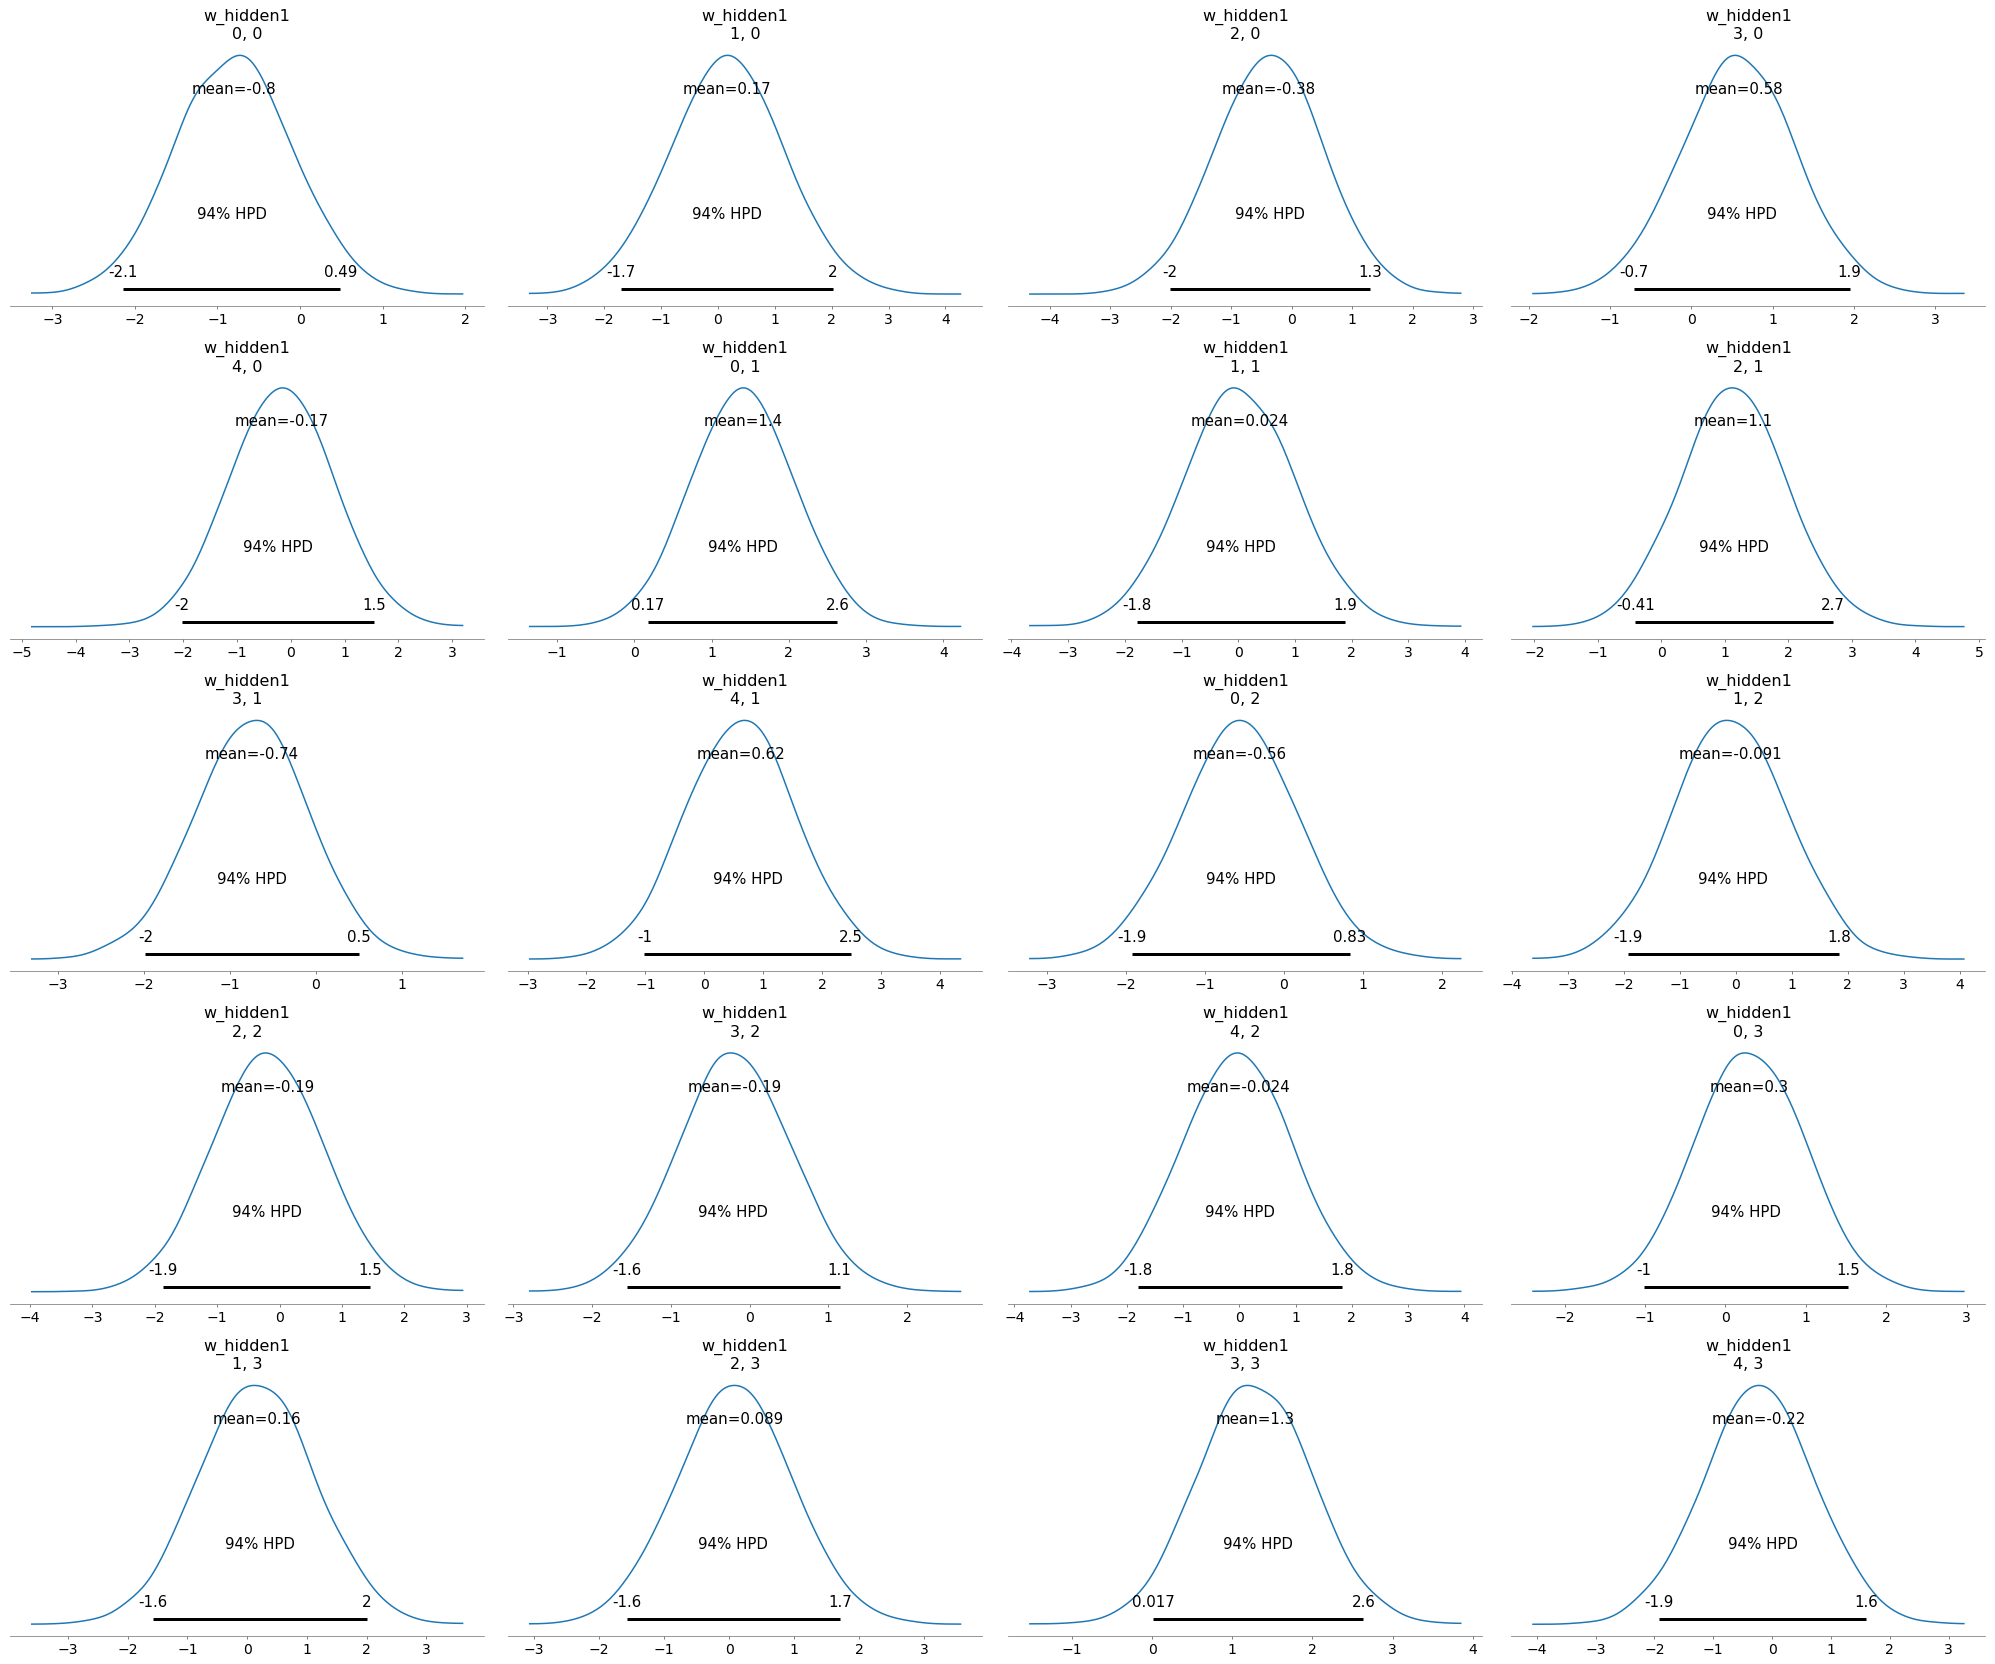

In [13]:
import arviz as az
with az.rc_context(rc={'plot.max_subplots': 20}):
    az.plot_posterior(trace)